# Failures Prediciton
This jupyter notebook describes how to train a ML model for predicting failures of devices in the factory.

#### Download data
The first step is downloading data. We use here a publicly available dataset. Let's download telemetry and failures  csv files.

In [2]:
import os
import urllib.request


REPOSITORY_PATH = "https://github.com/DeeptiChevvuri/Predictive-Maintenance-Modelling-Datasets/raw/master/"
TELEMETRY_FILE_NAME = "telemetry.csv"
FAILURES_FILE_NAME = "failures.csv"
DATA_FOLDER = "./data"


telemetry_path = os.path.join(DATA_FOLDER, TELEMETRY_FILE_NAME)
failures_path = os.path.join(DATA_FOLDER, FAILURES_FILE_NAME)

os.makedirs(DATA_FOLDER, exist_ok=True)


if not os.path.isfile(telemetry_path):
    urllib.request.urlretrieve(REPOSITORY_PATH + TELEMETRY_FILE_NAME, telemetry_path)
    
if not os.path.isfile(failures_path):
    urllib.request.urlretrieve(REPOSITORY_PATH + FAILURES_FILE_NAME, failures_path)

#### Read and prepare datasets
Now we are ready to read the datasets into pandas dataframes

In [3]:
import pandas as pd


telemetry_df = pd.read_csv(telemetry_path) 
telemetry_df['datetime'] = pd.to_datetime(telemetry_df['datetime'], format='%m/%d/%Y %I:%M:%S %p')
telemetry_df

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511
...,...,...,...,...,...,...
876095,2016-01-01 02:00:00,100,179.438162,395.222827,102.290715,50.771941
876096,2016-01-01 03:00:00,100,189.617555,446.207972,98.180607,35.123072
876097,2016-01-01 04:00:00,100,192.483414,447.816524,94.132837,48.314561
876098,2016-01-01 05:00:00,100,165.475310,413.771670,104.081073,44.835259


In real scenarios it's often better to run a separate model for each machine. It might be a separately trained model or just a fine tuned one. In current example scenario we are going to train one model for all machines. However, it's necessary first to ensure that the telemetry values do not differ too much. Box plots are very helpful for checking it.

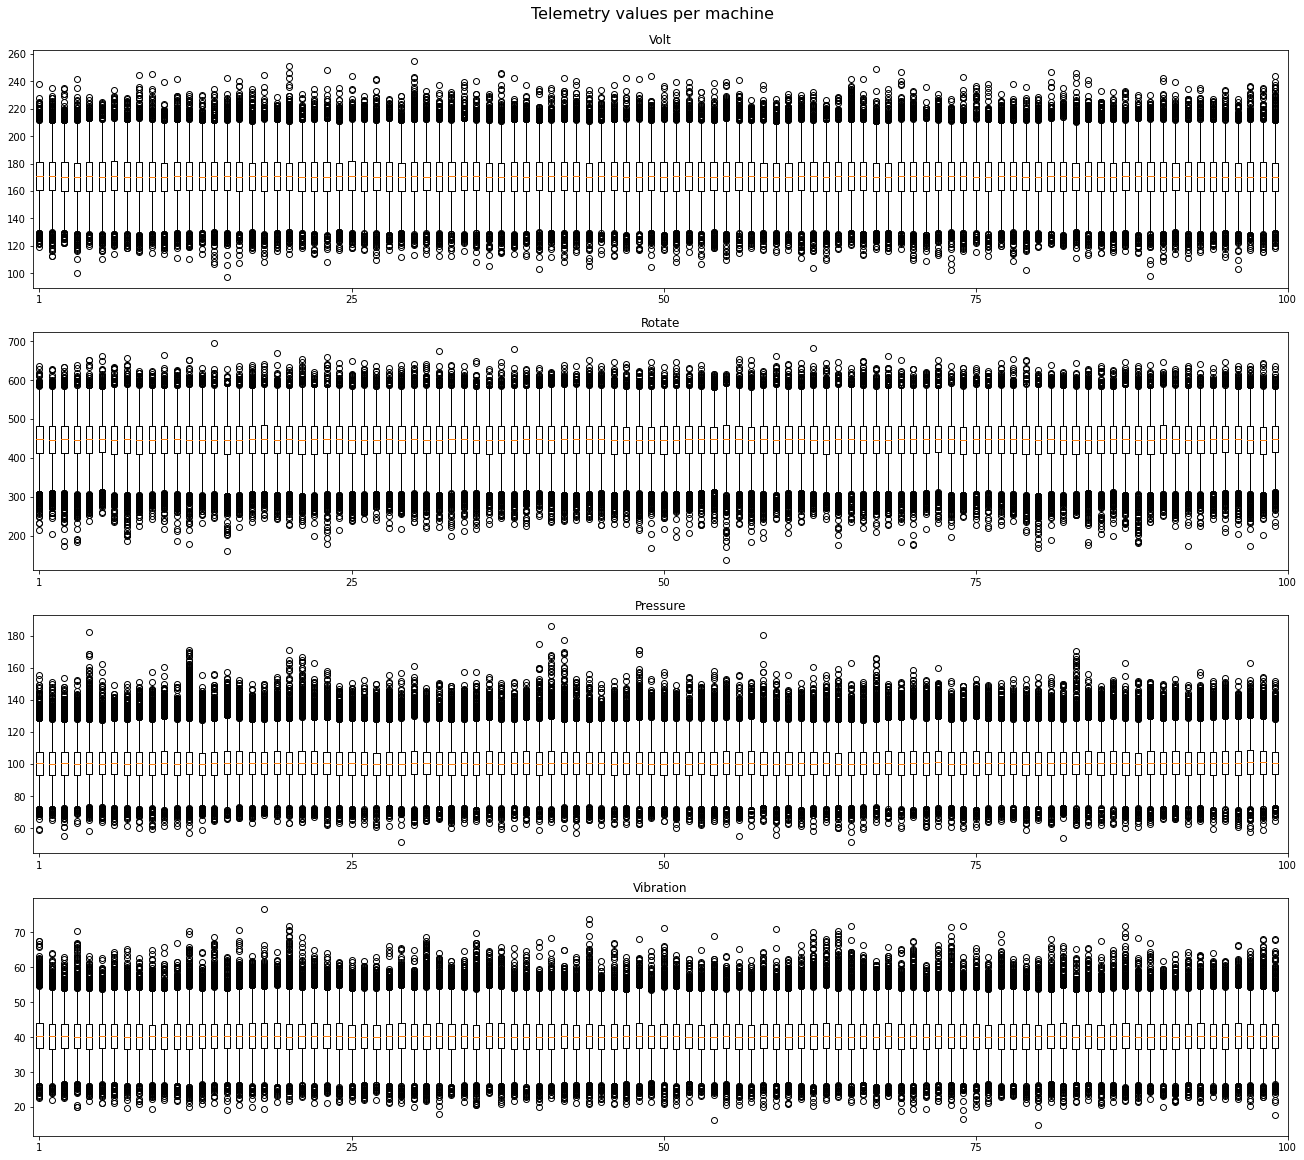

In [11]:
import matplotlib.pyplot as plt
import numpy as np


volt_values = []
rotate_values = []
pressure_values = []
vibration_values = []

for i in range(1,101):
    volt_values.append(telemetry_df[telemetry_df['machineID'] == i]["volt"])
    rotate_values.append(telemetry_df[telemetry_df['machineID'] == i]["rotate"])
    pressure_values.append(telemetry_df[telemetry_df['machineID'] == i]["pressure"])
    vibration_values.append(telemetry_df[telemetry_df['machineID'] == i]["vibration"])

    
fig, axs = plt.subplots(4, 1, constrained_layout=True, figsize=(18, 16))
fig.suptitle('Telemetry values per machine', fontsize=16)


def build_box_plot(plot_index, plot_values, title):
    axs[plot_index].boxplot(plot_values)
    axs[plot_index].set_title(title)
    axs[plot_index].set_xticks([1, 26, 51, 76, 101])
    axs[plot_index].set_xticklabels([1, 25, 50, 75, 100])

    
build_box_plot(0, volt_values, "Volt")
build_box_plot(1, rotate_values, "Rotate")
build_box_plot(2, pressure_values, "Pressure")
build_box_plot(3, vibration_values, "Vibration")
plt.show()

Looking at the boxplots we can see that most of the telemetry values are not very scattered. So we can try training one model for all the devices. 
Now we require to read the failures data and map it to the telemetry data frame. 

In [4]:
failures_df = pd.read_csv(failures_path) 
failures_df['datetime'] = pd.to_datetime(failures_df['datetime'], format='%m/%d/%Y %I:%M:%S %p')
failures_df

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4
...,...,...,...
756,2015-11-29 06:00:00,99,comp3
757,2015-12-14 06:00:00,99,comp4
758,2015-02-12 06:00:00,100,comp1
759,2015-09-10 06:00:00,100,comp1


In [8]:
failures = [False]*len(telemetry_df)

for machine_id in failures_df.machineID.unique():
    machine_telemetry = telemetry_df[telemetry_df.machineID==machine_id]
    
    for date_time in failures_df[failures_df.machineID == machine_id].datetime:
        for date_time_index in machine_telemetry.index[machine_telemetry.datetime==date_time]:                
            failures[date_time_index] = True

            
telemetry_df['failures'] = failures
print(sum(telemetry_df.failures))

719


In total there are less failures than rows in the failure table. The reason is that this table contains data on component level. Sometimes more than one component fails at the same time. We are more interested in total machine failures, thus ignoring too granular components information.
Now we can look into the telemetry value and compare them with normal. This way we can analyze if there is any stright forward depdendency between telemetry values and failures. To do this, let's build two scatter plots. 

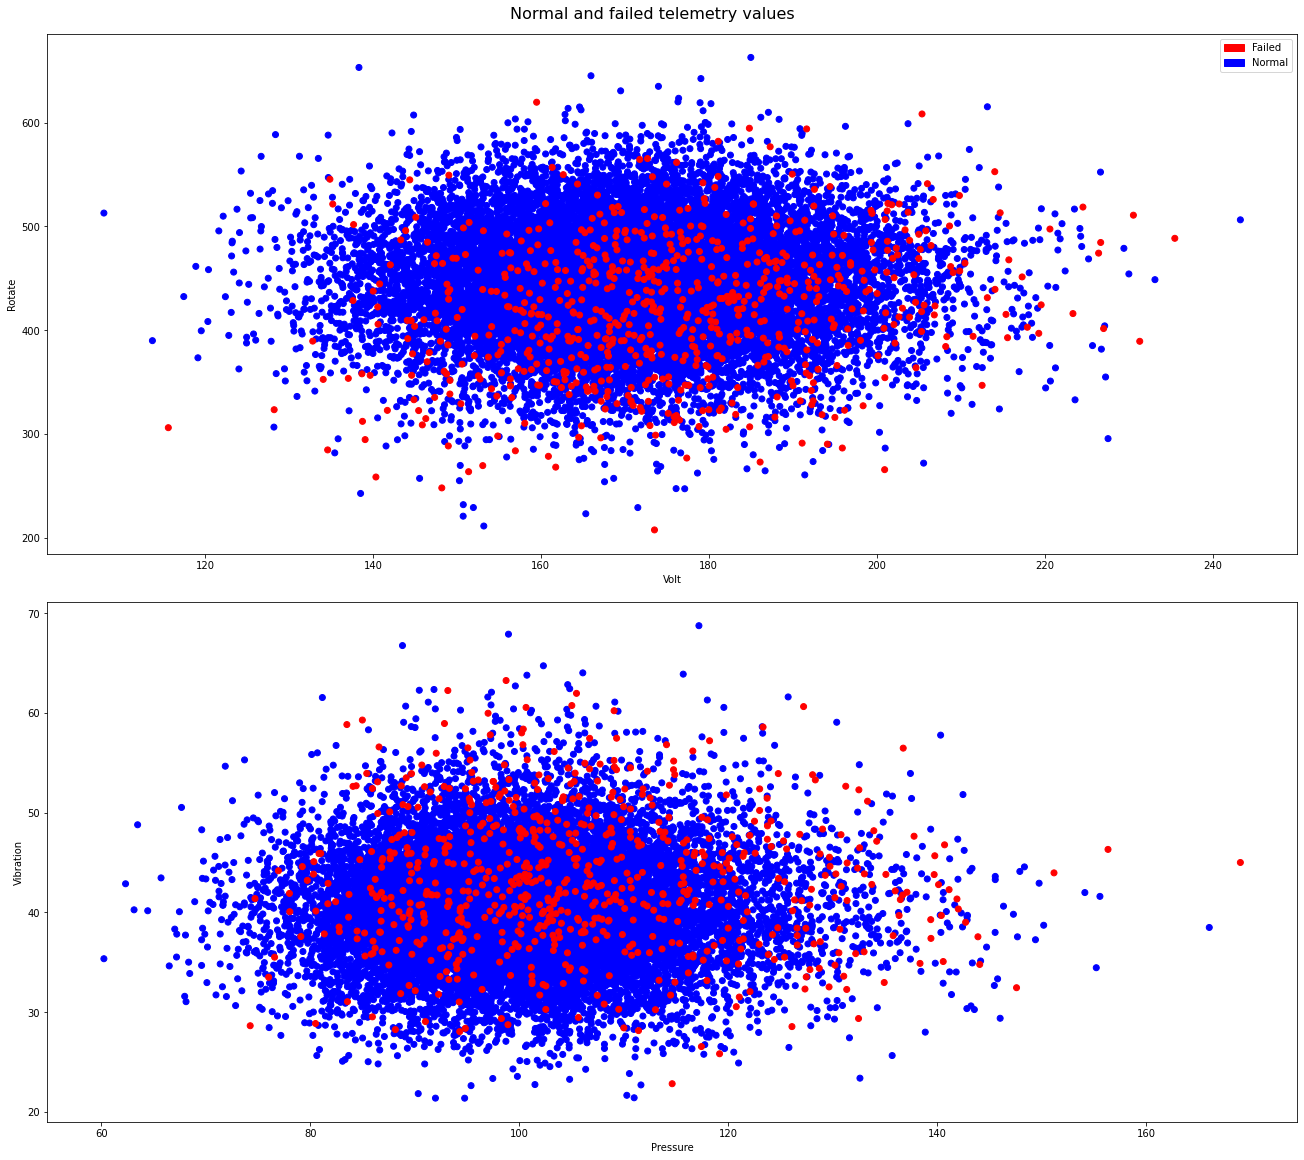

In [31]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt


colors = {True: "r", False: "b"}
tel_subsample_df = telemetry_df[telemetry_df.failures==False].sample(frac=0.02)
tel_subsample_df = pd.concat([tel_subsample_df, telemetry_df[telemetry_df.failures==True]])

fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(18, 16))
fig.suptitle('Normal and failed telemetry values', fontsize=16)
axs[0].legend(handles=[mpatches.Patch(color='r', label='Failed'), mpatches.Patch(color='b', label='Normal')])
axs[0].set_xlabel('Volt')
axs[0].set_ylabel('Rotate')
axs[0].scatter(tel_subsample_df.volt, tel_subsample_df.rotate, color=tel_subsample_df.failures.map(colors))
axs[1].set_xlabel('Pressure')
axs[1].set_ylabel('Vibration')
axs[1].scatter(tel_subsample_df.pressure, tel_subsample_df.vibration, color=tel_subsample_df.failures.map(colors))
pass